In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

In [2]:
file_path = 'C:/Users/chris/Downloads/singlecell_result/final_Result'

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')
tpm_dataframe = pd.read_csv('%s/HNSCC_all_data.csv' % file_path, index_col=0, dtype = object)


# gene 이름에 작은따옴표가 포함되어 있어서 제거하여준다.
tpm_row_name = []
for i in list(tpm_dataframe.index) :
    j = i.strip("'")
    tpm_row_name.append(j)
tpm_dataframe.index = tpm_row_name

# 컬럼명의 리스트를 만들어서, 해당 컬럼명을 '_'기준으로 split한다.
# 앞 부분이 sample명 이므로, 뽑아준다. 
tpm_columns = list(tpm_dataframe.columns)
sample_name = []
for string in tpm_columns :
    string_split = string.split('_')
    sample_name.append(string_split[0])



############## 5번 샘플에 대하여 뽑음 #############
HN5 = list(filter(lambda x:sample_name[x] == "HN5", range(len(sample_name))))
HNSCC5 = list(filter(lambda x:sample_name[x] == "HNSCC5", range(len(sample_name))))


reduced_sample_index = (HN5 + HNSCC5)


def patient_meta(cell_list, patient_name) :
    patient_list = []
    for i in range(len(cell_list)) :
        patient_list.append(patient_name)
    return patient_list


# sample별로 구분하기 위하여 metadata를 만들었다. 
p_HN5 = patient_meta(HN5, "P5")
p_HNSCC5 = patient_meta(HNSCC5, "P5")


reduced_patient_name = (p_HN5 + p_HNSCC5)


# reduced dataframe(5 samples) 을 만들어준다. 
reduced_tpm_dataframe_5sample = tpm_dataframe.iloc[:,reduced_sample_index]
# reduced dateframe 끝 행에 sample 이름 data를 추가한다.
main_df_5s = reduced_tpm_dataframe_5sample.copy()
main_df_5s.loc['sample name'] = reduced_patient_name


######### p-EMT marker genes의 expression average ##########

# reduced dateframe 끝 행에 p-EMT marker에 대해 expression 값을 평균낸다.
p_emt_gene = main_df_5s.loc[["TGFBI", "LAMC2", "PDPN", "ITGA5", "VIM","MMP10", "SERPINE1", "P4HA2", "LAMA3", "CDH13", "TNC"], :]

mean_list = []
for i in range(p_emt_gene.shape[1]) :
    total = 0
    for j in range(p_emt_gene.shape[0]) :
        total += float(p_emt_gene.iloc[j,i])
    total = total / 11
    mean_list.append(total)
    
# datafame 끝에 해당 값을 추가한다.
main_df_5s.loc['average p-EMT'] = mean_list

# sample name과 average p-EMT가 잘 들어갔나 확인했다.
main_df_5s.tail()

########## LN은 제외하고, malignant cell의 index를 뽑아준다 #############
malignant_index = []
for i in range(main_df_5s.shape[1]) :
    if ((main_df_5s.loc["Lymph node",:][i] == '0' and main_df_5s.loc["classified  as cancer cell",:][i] == '1')
        or (main_df_5s.loc['non-cancer cell type',:][i] == 'Fibroblast')) :
        malignant_index.append(i)
len(malignant_index)        

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.5.2 pandas==1.1.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


136

normalizing counts per cell
    finished (0:00:00)


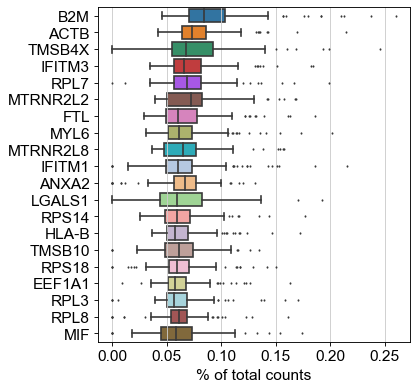

filtered out 8220 genes that are detected in less than 3 cells
... storing 'processed by Maxima enzyme' as categorical
... storing 'Lymph node' as categorical
... storing 'classified  as cancer cell' as categorical
... storing 'classified as non-cancer cells' as categorical
... storing 'non-cancer cell type' as categorical
... storing 'sample name' as categorical


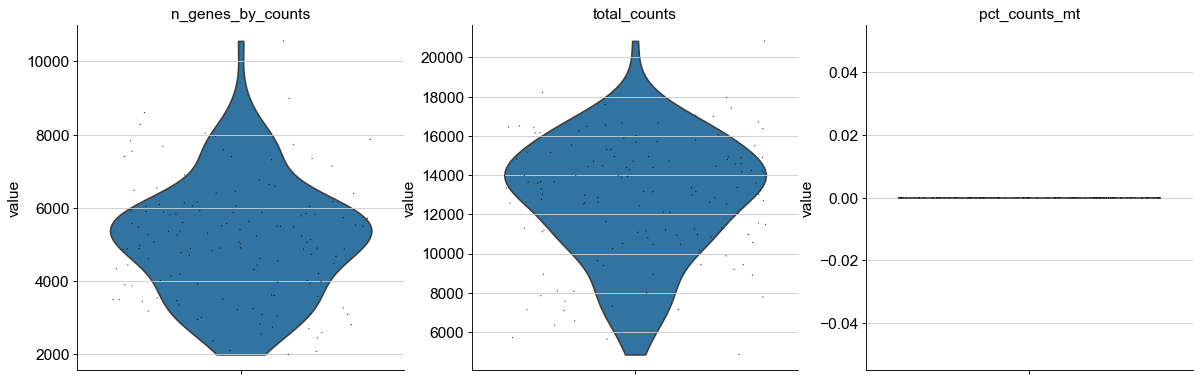

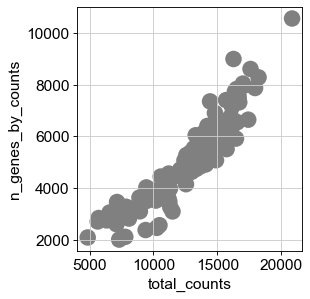

c:\users\chris\anaconda3\envs\py3.6\lib\site-packages\scanpy\preprocessing\_simple.py:375: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


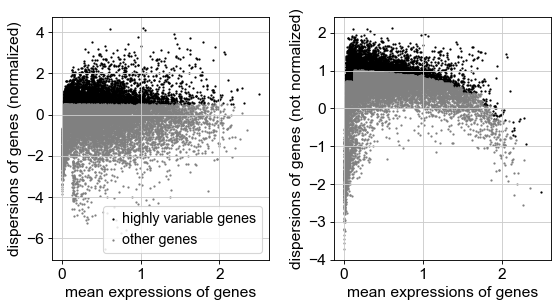

regressing out ['total_counts']
    finished (0:00:11)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


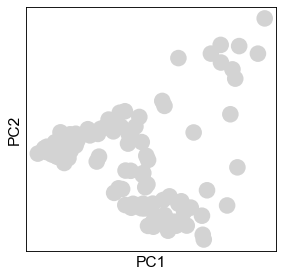

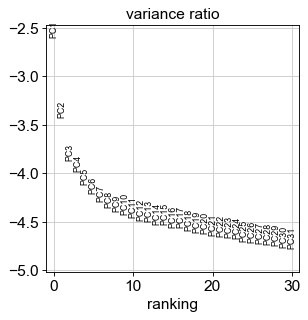

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


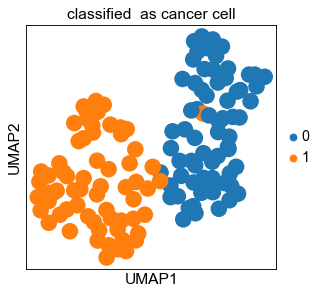

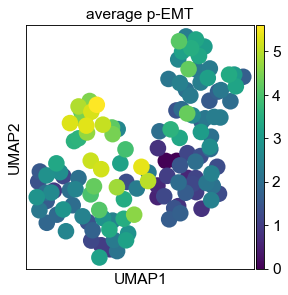

In [4]:
######### 5번 샘플의 malignant cell만 남은 것을 전처리 #########
main_df_5s_malignant = main_df_5s.iloc[:,malignant_index]
main_df_5s_malignant = main_df_5s_malignant.transpose()
metadata_dataframe = main_df_5s_malignant.iloc[:,[0,1,2,3,4,23691,23692]]
# matrix에서 metadata는 삭제하고, tpm만 남겨주었다. 
main_df_5s_malignant = main_df_5s_malignant.drop(['processed by Maxima enzyme', 'Lymph node',
       'classified  as cancer cell', 'classified as non-cancer cells',
       'non-cancer cell type', 'sample name', 'average p-EMT'], 1)
adata = sc.AnnData(X = main_df_5s_malignant, obs = metadata_dataframe)
adata.raw = adata
# Show those genes that yield the highest fraction of counts in each single cell, across all cells.
sc.pl.highest_expr_genes(adata, n_top=20, ) # expression 양이 높은 top gene 20 을 뽑음
sc.pp.filter_cells(adata, min_genes=200) # 200개 이하의 gene을 발현하는 cell을 삭제함
sc.pp.filter_genes(adata, min_cells=3) # 3개 이하의 cell에서 발현되는 gene을 삭제함
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
# mitochondria gene은 존재하지 않음

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
adata = adata[adata.obs.n_genes_by_counts < 9000, :]
adata = adata[adata.obs.n_genes_by_counts > 1000, :]


sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

adata.raw = adata # adata.raw에는 기존의 전체 유전자 다 넣음

adata = adata[:, adata.var.highly_variable]
# adata에는 higly_variable gene만 남긴다.

sc.pp.regress_out(adata, ['total_counts'])
# Regress out (mostly) unwanted sources of variation

sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata)
sc.pl.pca_variance_ratio(adata, log=True)

sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ['classified  as cancer cell'])
sc.pl.umap(adata, color = ['average p-EMT'])

In [5]:
############# 상관분석을 위한 데이터 전처리 #############

In [6]:
metarow =adata.obs.index # 행 이름 추출
pemt = adata.obs[['average p-EMT']]
pro = adata.obs[["classified  as cancer cell"]]
countrow = main_df_5s_malignant.index
temp = list(set(countrow) - set(metarow)) 
temp # 제거된 cell 찾음

['HNSCC5_p7_HNSCC5_P7_C07']

In [7]:
reduced_main = main_df_5s_malignant.drop(['HNSCC5_p7_HNSCC5_P7_C07']) # 제거
# 남은 세포들로 데이터프레임 만든다.
gene_sets = reduced_main.columns.tolist()
genes= reduced_main.loc[:,gene_sets]

In [8]:
# average p-EMT열을 추가한다.
pemt['average p-EMT'] = pd.to_numeric(pemt['average p-EMT'])
Genes = genes.astype(float)
cor_df = pd.concat([pemt, Genes], axis=1)
# malignant cell만 뽑는다.
fibroblast_Index = list(np.where(pro["classified  as cancer cell"]=='1')[0])
adata_df_cancer = cor_df.iloc[fibroblast_Index]

c:\users\chris\anaconda3\envs\py3.6\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
######### 상관분석 ###########

In [10]:
# 상관분석
cor_df = adata_df_cancer.corr(method = 'pearson')
# 상관계수 높은 것들만 뽑는다.
cor_high1 = list(np.where(cor_df['average p-EMT'] >= 0.4)[0])
cor_high2 = list(np.where(cor_df['average p-EMT'] <= -0.4)[0])
cor_high_list=list(set(cor_high1 + cor_high2))
# 상관계수 높은 것들만 가지는 데이터프레임을 만든다.
cor_df_high_positive = cor_df.iloc[cor_high1, :]
cor_df_high_negative = cor_df.iloc[cor_high2, :]

In [11]:
# 상관계수가 0.4이상인 것
cor_df_high_positive[['average p-EMT']]

,average p-EMT
average p-EMT,1.000000
MMP2,0.592404
SORL1,0.652932
COL18A1,0.565484
KRT15,0.450816
...,...
NFIB,0.484091
HSPA5,0.611791
PKM,0.483681
FKBP9,0.617920


In [12]:
# *.csv파일로 저장함
cor_df_high_positive[['average p-EMT']].to_csv("%s/cor_df_high_positive_sample5.csv" % file_path)

In [13]:
# *.csv파일로 저장함
cor_df_high_negative[['average p-EMT']].to_csv("%s/cor_df_high_negative_sample5.csv" % file_path)

In [14]:
#25번 샘플과 5번 샘플의 상관분석 결과에서 공통적인 것을 찾아주기 위한 과정이다.
sample5_positive_cor = list(cor_df_high_positive.index)

In [15]:
sample25_positive_cor = [
 'MMP2',
 'ASS1',
 'FST',
 'SDK2',
 'PDLIM1',
 'LEPRE1',
 'IFITM3',
 'SDCBP',
 'CTNNAL1',
 'SLC38A5',
 'SERPING1',
 'CD99',
 'LAMB3',
 'PIK3CD',
 'EFEMP1',
 'COL4A2',
 'TAX1BP3',
 'SLC39A13',
 'LAMC2',
 'ACSL4',
 'SLC7A8',
 'ANXA5',
 'JAG2',
 'SERPINH1',
 'DST',
 'NEDD9',
 'AREG',
 'LAMA3',
 'BGN',
 'MMP1',
 'THBS1',
 'CALD1',
 'COL12A1',
 'PTHLH',
 'ITGB6',
 'VIM',
 'SPHK1',
 'PLOD3',
 'TNS4',
 'PRSS23',
 'COL5A1',
 'CSPG4',
 'ARPC1B',
 'GPX1',
 'C1R',
 'CDH13',
 'APMAP',
 'LIMA1',
 'SEMA3C',
 'TP63',
 'CXCR7',
 'ITGA2',
 'AXL',
 'ODC1',
 'CRIP1',
 'SLC1A3',
 'IGFBP3',
 'C12orf23',
 'SLC39A14',
 'B4GALT1',
 'IGFBP7',
 'ARL4C',
 'PDPN',
 'IVNS1ABP',
 'SERPINE2',
 'COL17A1',
 'PXN',
 'ITGB1',
 'C1S',
 'C1QTNF6',
 'TPM2',
 'SLC16A1',
 'DLL1',
 'SDC4',
 'FHL2',
 'VAV2',
 'LOXL2',
 'SERPINE1',
 'TGFBI',
 'ITGA5',
 'NPNT',
 'MT2A',
 'TIMP3',
 'ITGB4',
 'LGALS3BP',
 'G0S2',
 'CAV1',
 'SPARC',
 'RHOC',
 'LTBP1',
 'ITGA6',
 'DKK3',
 'EMP3',
 'P4HA1',
 'COL4A1',
 'MYADM',
 'PRKCDBP',
 'MYH9',
 'TNC',
 'SLC7A5',
 'IFNK']

In [16]:
result_both_positive = list(set(sample5_positive_cor) & set(sample25_positive_cor))

In [17]:
cor_df_high_positive_both = cor_df_high_positive[['average p-EMT']].loc[result_both_positive]

In [18]:
cor_df_high_positive_both.to_csv("%s/cor_df_high_positive_sample5_both.csv" % file_path)

In [19]:
sample5_negative_cor = list(cor_df_high_negative.index)

In [20]:
sample25_negative_cor = ['KLK7',
 'NCCRP1',
 'GRHL3',
 'RHOV',
 'KRT6C',
 'KRTDAP',
 'LYPD3',
 'KRT16',
 'FABP5',
 'PKP1',
 'IRF5',
 'MAL2',
 'GRHL1',
 'ZNF750',
 'KRT80',
 'LYNX1',
 'KRT6B',
 'SBSN',
 'C9orf169',
 'CLDN4',
 'AIM1L',
 'LY6D',
 'ARHGEF10L',
 'CALML5',
 'AMY1A',
 'ALDH3B2',
 'C2orf54']

In [21]:
result_both_negative = list(set(sample5_negative_cor) & set(sample25_negative_cor))

In [22]:
cor_df_high_negative_both = cor_df_high_negative[['average p-EMT']].loc[result_both_negative]

In [23]:
cor_df_high_negative_both.to_csv('%s/cor_df_high_negative_sample5_both.csv' % file_path)

In [24]:
################ cellinker 파일 만들기 ################

In [25]:
metarow =adata.obs.index # 행 이름 추출

In [26]:
pemt = adata.obs[['average p-EMT']]
pro = adata.obs[["classified  as cancer cell"]]
pemt_pro = pd.concat([pemt, pro], axis=1)

In [27]:
pemt_high_Index = list(np.where(pemt_pro["average p-EMT"] >= 3.5)[0]) # 평균 발현량이 3.5 이상인 cell의 인덱스를 뽑았다.
fibroblast_Index = list(np.where(pemt_pro["classified  as cancer cell"]=='0')[0]) # fibroblast의 인덱스를 뽑았다.
mylist=list(set(pemt_high_Index + fibroblast_Index))

In [28]:
countrow = main_df_5s_malignant.index

In [29]:
temp = list(set(countrow) - set(metarow)) 

In [30]:
temp # 제거된 cell 찾음

['HNSCC5_p7_HNSCC5_P7_C07']

In [31]:
reduced_main = main_df_5s_malignant.drop(['HNSCC5_p7_HNSCC5_P7_C07'])

In [32]:
cellink_df_final = reduced_main.iloc[mylist]

In [33]:
pro_final = pro.iloc[mylist]

In [34]:
pro_final['classified  as cancer cell'] = pro_final['classified  as cancer cell'].replace({'0': 'Fibroblast', '1':'Epithelial'})

c:\users\chris\anaconda3\envs\py3.6\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
pro_final.to_csv('%s/5_malignant_fibro_upper3.5.txt' % file_path,index=True,sep='\t')

In [36]:
cellink_df_final = cellink_df_final.transpose()

In [37]:
cellink_df_final.to_csv('%s/5_tpm_malignant_fibro_upper3.5.txt' % file_path,index=True,sep='\t')